# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 18:57:07.175062: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 18:57:07.175115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 18:57:07.176603: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-4, who has ID: A3U2NAO7853MW

In [2]:
parameters = {}

user = "users-4"
user_id = "A3U2NAO7853MW"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A3LSI954URFAJ3,B000084EEF,B004JBB22G,B015D67968
1,A3PZARP3I8BWZH,B000084EEF,B00WMMMHNM,B00UXY3NM0
2,A19YJWD8OAZX2S,B000084EEF,B01AT89OEA,B018OI4I66
3,A2RSXF64W7VW31,B008PNN8DK,B000YK7V9O,B00074VWJM
4,A2RSXF64W7VW31,B000084EEF,B000QOIX4U,B0006G511G
...,...,...,...,...
44849,A2HV6QMVXUF24K,B01DMM5QU6,B00DE7WACC,B000084E7Y
44850,A95KQ6NL9YEAY,B01EIZKCSM,B0012T6KRU,B01DOO1ZHU
44851,ALPQ54E2E9E0Z,B01EZF6PM2,B01DAWYRKI,B01DU349W8
44852,ATZFJWON5C3U1,B01FOZPFNW,B014SDTHF8,B00N2EWFV8


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 44854
Number of sequences and targets after removal: 44021


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A3U2NAO7853MW
productID                B000QSRNTM
purchased_before_1       B00QPLUWD8
purchased_before_2       B004M3IKSU
Name: 1019, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 44020
Number of sequences and targets after dropping duplicates: 41851


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 130
Number of unique product IDs in sequences: 19285


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B004JBB22G', 'B015D67968'],
        ['B00WMMMHNM', 'B00UXY3NM0'],
        ['B000YK7V9O', 'B00074VWJM'],
        ['B000QOIX4U', 'B0006G511G'],
        ['B004V4BXTI', 'B000084EEF'],
        ['B014E2AGYE', 'B004V4BXTI'],
        ['B0002DIRXC', 'B00OILVTES'],
        ['B004XZB0QQ', 'B001TA5O9C'],
        ['B0151JV6MK', 'B017P1QSC0'],
        ['B000084EXU', 'B000IVGBFY']], dtype=object),
 array(['B000084EEF', 'B000084EEF', 'B008PNN8DK', 'B000084EEF',
        'B00JRCBG0U', 'B000084EEF', 'B000084EEF', 'B000084EEF',
        'B000084EEF', 'B000UGB9EA'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[39213, 125538],
        [115747, 113153],
        [19262, 8557],
        [16286, 7620],
        [41116, 275],
        [124024, 41116],
        [4429, 103905],
        [41871, 27662],
        [125048, 129218],
        [328, 13543]], dtype=object),
 array([275, 275, 59882, 275, 92081, 275, 275, 275, 275, 17244],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 33448
Number of validation sequences: 4200
Number of test sequences: 4203

Number of train targets: 33448
Number of validation targets: 4200
Number of test targets: 4203

Number of classes (unique product IDs) in the train targets: 116
Number of classes in the validation targets: 127
Number of classes in the test targets: 130


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([20420, 10959], dtype=object),
 array([86954, 98947], dtype=object),
 array([74474, 91220], dtype=object),
 array([2533, 67035], dtype=object),
 array([129699, 129702], dtype=object),
 array([17919, 17919], dtype=object),
 array([104553, 4771], dtype=object),
 array([79508, 29814], dtype=object),
 array([23605, 94836], dtype=object),
 array([40218, 7390], dtype=object)]

In [19]:
y_train[:10]

[275, 275, 275, 275, 275, 275, 275, 275, 275, 275]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
  27/1046 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.0810 - f1_score: 0.0653 - f1_score_at_k: 0.1317 - hit_rate_at_k: 0.3826 - loss: 11.8283 - ndcg_at_k: 0.0780                     

I0000 00:00:1714589842.623698    5972 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1046/1046 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.1068 - f1_score: 0.0461 - f1_score_at_k: 0.0952 - hit_rate_at_k: 0.4015 - loss: 7.2152 - ndcg_at_k: 0.0855 - val_accuracy: 0.0500 - val_f1_score: 0.0602 - val_f1_score_at_k: 0.1854 - val_hit_rate_at_k: 0.1785 - val_loss: 4.2385 - val_ndcg_at_k: 0.0382
Epoch 2/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1230 - f1_score: 0.0599 - f1_score_at_k: 0.1009 - hit_rate_at_k: 0.3882 - loss: 3.6866 - ndcg_at_k: 0.0861 - val_accuracy: 0.0657 - val_f1_score: 0.0836 - val_f1_score_at_k: 0.2203 - val_hit_rate_at_k: 0.1934 - val_loss: 4.2046 - val_ndcg_at_k: 0.0442
Epoch 3/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1591 - f1_score: 0.0944 - f1_score_at_k: 0.1412 - hit_rate_at_k: 0.4239 - loss: 3.5509 - ndcg_at_k: 0.0991 - val_accuracy: 0.0640 - val_f1_score: 0.0875 - val_f1_score_at_k: 0.2702 - val_hit_rate_at_k: 0.2244 - val_loss: 4.1731 - val_ndcg_at_k: 0.0489
Epoch 4/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/

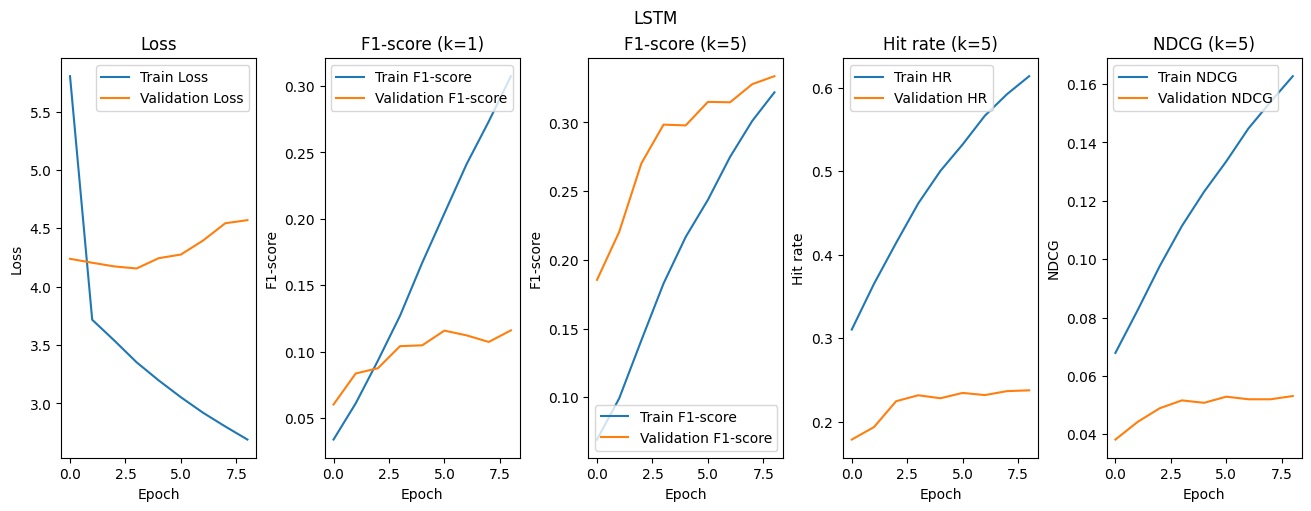

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0327 - f1_score: 0.0533 - f1_score_at_k: 0.2464 - hit_rate_at_k: 0.1647 - loss: 4.7663 - ndcg_at_k: 0.0330
Test loss: 4.5962
Test accuracy: 0.0792
Test F1@1: 0.1232
Test F1@5: 0.3321
Test HR@5: 0.2393
Test NDCG@5: 0.0539


In [32]:
parameters

{'user': 'users-4',
 'user_id': 'A3U2NAO7853MW',
 'number_of_sequences_and_targets_before_removal': 44854,
 'number_of_sequences_and_targets_after_removal': 44021,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 41851,
 'num_unique_product_ids_in_targets': 130,
 'num_unique_product_ids_in_sequences': 19285,
 'number_of_sequences_and_targets_train': 33448,
 'number_of_sequences_and_targets_validation': 4200,
 'number_of_sequences_and_targets_test': 4203,
 'number_of_unique_products_in_targets_train': 116,
 'number_of_unique_products_in_targets_validation': 127,
 'number_of_unique_products_in_targets_test': 130,
 'model_lstm_test_loss': 4.596165180206299,
 'model_lstm_test_accuracy': 0.0792,
 'model_lstm_test_f1_score_k_1': 0.1232,
 'model_lstm_test_f1_score_k_5': 0.3321,
 'model_lstm_test_hr': 0.2393,
 'model_lstm_test_ndcg': 0.0539}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 31s 17ms/step - accuracy: 0.0992 - f1_score: 0.0444 - f1_score_at_k: 0.0980 - hit_rate_at_k: 0.4004 - loss: 6.7548 - ndcg_at_k: 0.0838 - val_accuracy: 0.0474 - val_f1_score: 0.0555 - val_f1_score_at_k: 0.1800 - val_hit_rate_at_k: 0.1664 - val_loss: 4.2700 - val_ndcg_at_k: 0.0355
Epoch 2/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1161 - f1_score: 0.0454 - f1_score_at_k: 0.1009 - hit_rate_at_k: 0.3885 - loss: 3.6888 - ndcg_at_k: 0.0851 - val_accuracy: 0.0548 - val_f1_score: 0.0716 - val_f1_score_at_k: 0.2165 - val_hit_rate_at_k: 0.1877 - val_loss: 4.2086 - val_ndcg_at_k: 0.0416
Epoch 3/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1463 - f1_score: 0.0848 - f1_score_at_k: 0.1418 - hit_rate_at_k: 0.4285 - loss: 3.5301 - ndcg_at_k: 0.0979 - val_accuracy: 0.0760 - val_f1_score: 0.1073 - val_f1_score_at_k: 0.2758 - val_hit_rate_at_k: 0.2277 - val_loss: 4.1293 - val_ndcg_at_k: 0.0516
Epoch 4/50
1046/1046 ━━━━━━━━━━━━━━━━━

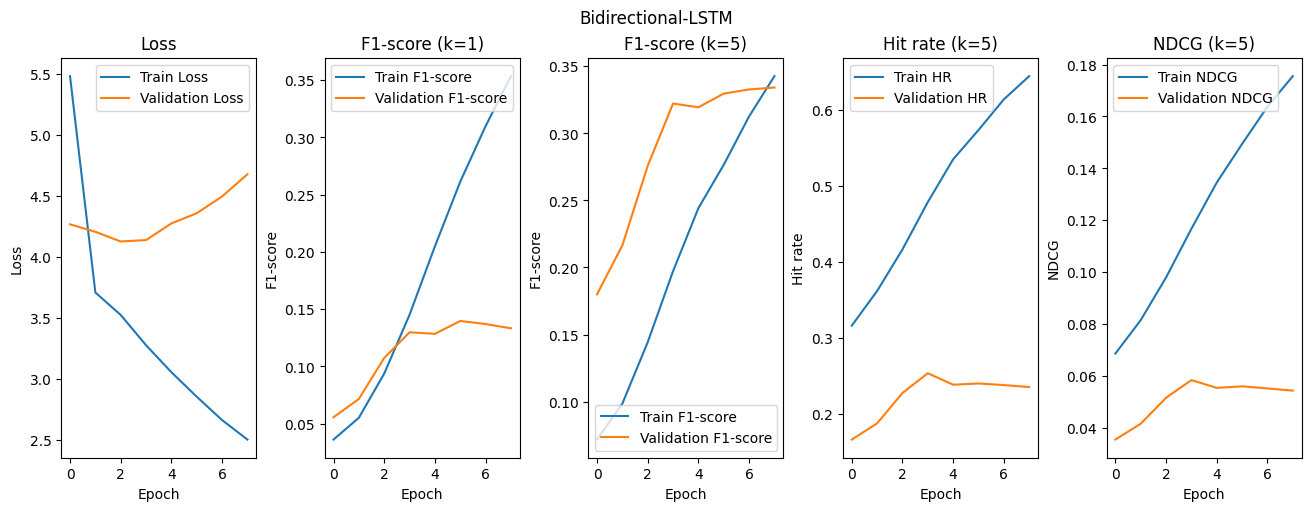

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0482 - f1_score: 0.0804 - f1_score_at_k: 0.2570 - hit_rate_at_k: 0.1671 - loss: 4.9058 - ndcg_at_k: 0.0356
Test loss: 4.7452
Test accuracy: 0.0842
Test F1@1: 0.1339
Test F1@5: 0.3282
Test HR@5: 0.2304
Test NDCG@5: 0.0531


In [37]:
parameters

{'user': 'users-4',
 'user_id': 'A3U2NAO7853MW',
 'number_of_sequences_and_targets_before_removal': 44854,
 'number_of_sequences_and_targets_after_removal': 44021,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 41851,
 'num_unique_product_ids_in_targets': 130,
 'num_unique_product_ids_in_sequences': 19285,
 'number_of_sequences_and_targets_train': 33448,
 'number_of_sequences_and_targets_validation': 4200,
 'number_of_sequences_and_targets_test': 4203,
 'number_of_unique_products_in_targets_train': 116,
 'number_of_unique_products_in_targets_validation': 127,
 'number_of_unique_products_in_targets_test': 130,
 'model_lstm_test_loss': 4.596165180206299,
 'model_lstm_test_accuracy': 0.0792,
 'model_lstm_test_f1_score_k_1': 0.1232,
 'model_lstm_test_f1_score_k_5': 0.3321,
 'model_lstm_test_hr': 0.2393,
 'model_lstm_test_ndcg': 0.0539,
 'model_bi_lstm_test_loss': 4.745238780975342,
 'model_bi_lstm_test_accuracy': 0.0842,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 25s 14ms/step - accuracy: 0.1061 - f1_score: 0.0439 - f1_score_at_k: 0.0960 - hit_rate_at_k: 0.4045 - loss: 7.1750 - ndcg_at_k: 0.0859 - val_accuracy: 0.0707 - val_f1_score: 0.0840 - val_f1_score_at_k: 0.1858 - val_hit_rate_at_k: 0.1705 - val_loss: 4.2269 - val_ndcg_at_k: 0.0408
Epoch 2/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1145 - f1_score: 0.0496 - f1_score_at_k: 0.0985 - hit_rate_at_k: 0.3803 - loss: 3.7021 - ndcg_at_k: 0.0834 - val_accuracy: 0.0762 - val_f1_score: 0.1007 - val_f1_score_at_k: 0.2455 - val_hit_rate_at_k: 0.2150 - val_loss: 4.1644 - val_ndcg_at_k: 0.0489
Epoch 3/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.1469 - f1_score: 0.0869 - f1_score_at_k: 0.1386 - hit_rate_at_k: 0.4170 - loss: 3.5819 - ndcg_at_k: 0.0958 - val_accuracy: 0.0762 - val_f1_score: 0.1016 - val_f1_score_at_k: 0.2560 - val_hit_rate_at_k: 0.2126 - val_loss: 4.1522 - val_ndcg_at_k: 0.0486
Epoch 4/50
1046/1046 ━━━━━━━━━━━━━━━━━

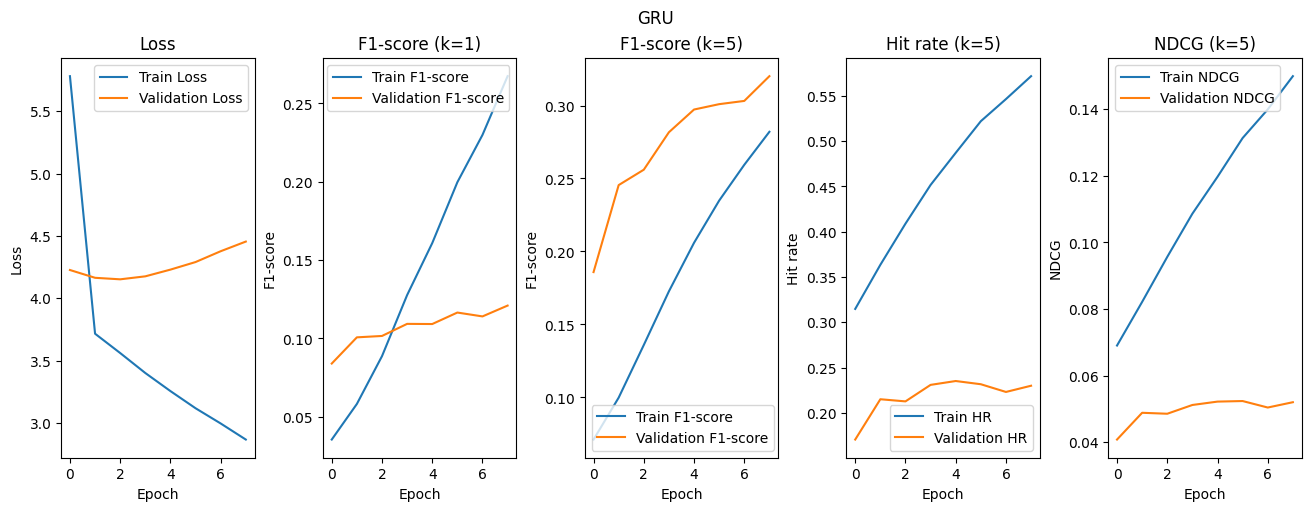

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0396 - f1_score: 0.0644 - f1_score_at_k: 0.2383 - hit_rate_at_k: 0.1626 - loss: 4.7043 - ndcg_at_k: 0.0337
Test loss: 4.4436
Test accuracy: 0.0811
Test F1@1: 0.1265
Test F1@5: 0.3335
Test HR@5: 0.2426
Test NDCG@5: 0.0547


In [42]:
parameters

{'user': 'users-4',
 'user_id': 'A3U2NAO7853MW',
 'number_of_sequences_and_targets_before_removal': 44854,
 'number_of_sequences_and_targets_after_removal': 44021,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 41851,
 'num_unique_product_ids_in_targets': 130,
 'num_unique_product_ids_in_sequences': 19285,
 'number_of_sequences_and_targets_train': 33448,
 'number_of_sequences_and_targets_validation': 4200,
 'number_of_sequences_and_targets_test': 4203,
 'number_of_unique_products_in_targets_train': 116,
 'number_of_unique_products_in_targets_validation': 127,
 'number_of_unique_products_in_targets_test': 130,
 'model_lstm_test_loss': 4.596165180206299,
 'model_lstm_test_accuracy': 0.0792,
 'model_lstm_test_f1_score_k_1': 0.1232,
 'model_lstm_test_f1_score_k_5': 0.3321,
 'model_lstm_test_hr': 0.2393,
 'model_lstm_test_ndcg': 0.0539,
 'model_bi_lstm_test_loss': 4.745238780975342,
 'model_bi_lstm_test_accuracy': 0.0842,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - accuracy: 0.0569 - f1_score: 0.0405 - f1_score_at_k: 0.0818 - hit_rate_at_k: 0.2177 - loss: 8.9023 - ndcg_at_k: 0.0464 - val_accuracy: 0.0595 - val_f1_score: 0.0710 - val_f1_score_at_k: 0.2008 - val_hit_rate_at_k: 0.1918 - val_loss: 4.1918 - val_ndcg_at_k: 0.0423
Epoch 2/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.1032 - f1_score: 0.0474 - f1_score_at_k: 0.0986 - hit_rate_at_k: 0.3625 - loss: 3.7410 - ndcg_at_k: 0.0787 - val_accuracy: 0.0557 - val_f1_score: 0.0725 - val_f1_score_at_k: 0.1924 - val_hit_rate_at_k: 0.1828 - val_loss: 4.2257 - val_ndcg_at_k: 0.0401
Epoch 3/50
1046/1046 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.1079 - f1_score: 0.0520 - f1_score_at_k: 0.1004 - hit_rate_at_k: 0.3656 - loss: 3.7644 - ndcg_at_k: 0.0799 - val_accuracy: 0.0657 - val_f1_score: 0.0848 - val_f1_score_at_k: 0.2179 - val_hit_rate_at_k: 0.1925 - val_loss: 4.2050 - val_ndcg_at_k: 0.0442
Epoch 4/50
1046/1046 ━━━━━━━━━━━━━━━━━

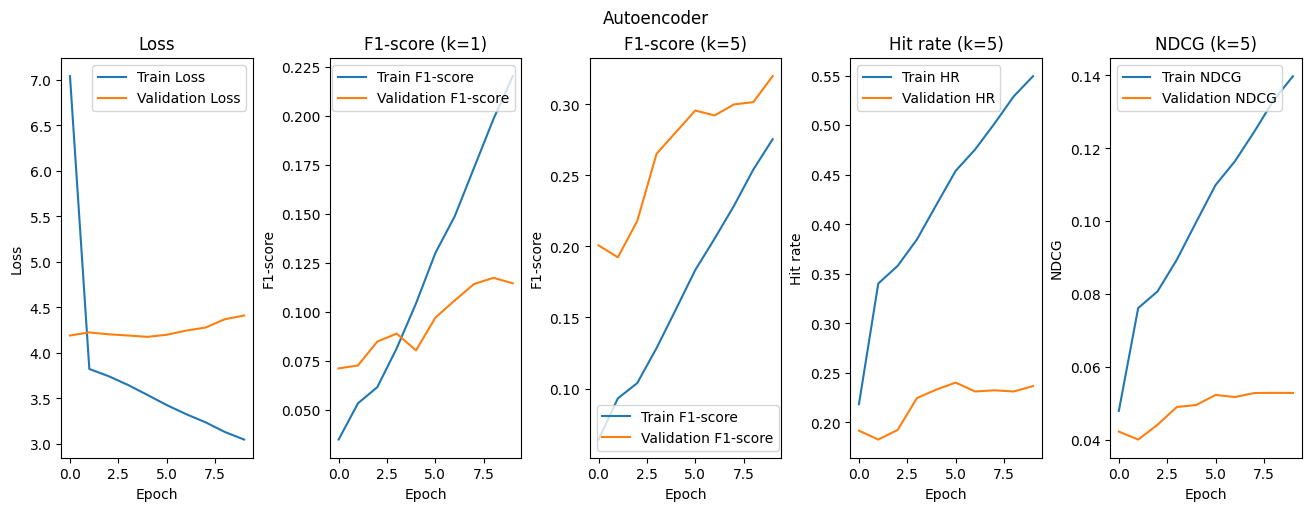

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

132/132 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.0352 - f1_score: 0.0563 - f1_score_at_k: 0.2373 - hit_rate_at_k: 0.1623 - loss: 4.5913 - ndcg_at_k: 0.0323
Test loss: 4.3887
Test accuracy: 0.0792
Test F1@1: 0.1185
Test F1@5: 0.3249
Test HR@5: 0.2386
Test NDCG@5: 0.054


In [47]:
parameters

{'user': 'users-4',
 'user_id': 'A3U2NAO7853MW',
 'number_of_sequences_and_targets_before_removal': 44854,
 'number_of_sequences_and_targets_after_removal': 44021,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 41851,
 'num_unique_product_ids_in_targets': 130,
 'num_unique_product_ids_in_sequences': 19285,
 'number_of_sequences_and_targets_train': 33448,
 'number_of_sequences_and_targets_validation': 4200,
 'number_of_sequences_and_targets_test': 4203,
 'number_of_unique_products_in_targets_train': 116,
 'number_of_unique_products_in_targets_validation': 127,
 'number_of_unique_products_in_targets_test': 130,
 'model_lstm_test_loss': 4.596165180206299,
 'model_lstm_test_accuracy': 0.0792,
 'model_lstm_test_f1_score_k_1': 0.1232,
 'model_lstm_test_f1_score_k_5': 0.3321,
 'model_lstm_test_hr': 0.2393,
 'model_lstm_test_ndcg': 0.0539,
 'model_bi_lstm_test_loss': 4.745238780975342,
 'model_bi_lstm_test_accuracy': 0.0842,
 'model_bi_lstm_test_f1_score_k_1': 0.1

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A3U2NAO7853MW', 'sequence': [107367, 39858], 'target': 16399}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 1.0
NDCG@50: 0.01499693002551794
-------------
HT@100: 1.0
NDCG@100: 0.009237757883965969
-------------
HT@200: 1.0
NDCG@200: 0.005555345676839352
-------------
HT@300: 1.0
NDCG@300: 0.004082546103745699
-------------
HT@400: 1.0
NDCG@400: 0.0032666728366166353
-------------
HT@500: 1.0
NDCG@500: 0.002741428092122078
-------------
